## Switching density networks for pendulum controller identification

This notebook provides a minimum working example of an SDN. Here we consider the task of controller identification for an inverted pendulum. For ease of comparison, we train on the full action space for a known hybrid controller.

Here, we seek to identify the 3 controllers producing actions $u$ that balance a pendulum given state space measurements (angle $\theta$, velocity $\dot{\theta}$):

Pump:
$$ u = K_1\dot{\theta} $$
Spin:
$$ u = -K_2\dot{\theta} $$
Balance
$$ u = +K_3\theta + K_4\dot{\theta} $$

We train an SDN to predict the gains for each controller region. For simplicity, we assume that measurement noise is known, and do not predict this. 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
# from numpy.random import seed
# seed(150)
from matplotlib import pyplot as plt
%matplotlib inline
import glob
import cv2
from IPython import display
from scipy.stats import multivariate_normal
import tensorflow as tf
from tensorflow_probability import distributions as tfd

import numpy as np
from keras.models import Model
from keras import regularizers
import keras.backend as K
from keras.layers import Input, Lambda, Dense, Concatenate
from keras.layers import Flatten, Dropout, Conv2D, Conv2DTranspose 
from keras.layers import Reshape, Softmax, BatchNormalization
from keras.callbacks import TensorBoard, Callback
from keras.optimizers import SGD, Adam
from keras.utils import Sequence
import time
import gym

/home/mburke33/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mburke33/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mburke33/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mburke33/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [3]:
class SDN:
    
    def __init__(self,nk=3,d=2):

        self.nk = nk
        self.d = d
        
        # Define model
        state = Input(shape=(2,))
        x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.01))(state)
        x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
        x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
        x = Dense(self.nk,activation='linear')(x)
        tau = Input(shape=(1,))
        
        goal_pi = Lambda(self.gumbel_softmax)([x,tau])
        goal_mu = Dense(self.d,activation='linear')(goal_pi)
        
        goal_out = Concatenate()([goal_mu, goal_pi])
        
        self.goal_pred = Model([state,tau],[goal_out,goal_pi])
        
        class_in = Input(shape=(self.nk,))
        self.class_pred = Model(class_in,self.predict_mu(class_in))
        
        goal_mu = self.class_pred(goal_pi)
        
        goal_out = Concatenate()([goal_mu, goal_pi])
        
        self.goal_pred = Model([state,tau],[goal_out,goal_pi])
        
        opt = Adam(lr=5e-3) # learning rate is high, should be much lower for harder problems
        
        self.goal_pred.compile(loss=[self.ga_loss(state),self.ce_loss], metrics=[self.temp_monitor_c(self.goal_pred.inputs[1])],optimizer=opt)
        
    def predict_mu(self,x):
        return Dense(self.d,activation='linear')(x)

    # Temperature monitor
    def temp_monitor_c(self,temp):
        def temp_monitor(y_true,y_pred):
            return tf.reduce_mean(temp)
        return temp_monitor

    # Gumbel Softmax
    def sample_gumbel(self,shape, eps=1e-20): 

        U = tf.random_uniform(shape,minval=0,maxval=1)
        return -tf.log(-tf.log(U + eps) + eps)

    def gumbel_softmax_sample(self, logits, temperature): 

        y = logits + self.sample_gumbel(tf.shape(logits))
        return tf.nn.softmax( y / temperature)

    def gumbel_softmax(self,l_t,hard=False):
        logits = l_t[0]
        temperature = l_t[1]
        y = self.gumbel_softmax_sample(logits, temperature)
        if hard:
            k = tf.shape(logits)[-1]
            y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
            y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
            y = tf.stop_gradient(y_hard - y) + y
        return y
    
    # Cross entropy loss
    def ce_loss(self,y_t,y_p):
        
        y_hat_t = tf.reduce_mean(y_t,axis=0)
        y_hat_p = tf.reduce_mean(y_p,axis=0)
        
        l2 = K.categorical_crossentropy(y_hat_t,y_hat_p)
        return l2
    
    # Proportional controller loss
    def ga_loss(self,state):
        def loss(y_true, y_pred):

            y_true = tf.reshape(y_true, [-1, 1], name='reshape_ytrue')

            out_mu, out_pi = tf.split(y_pred, num_or_size_splits=[self.d,self.nk],axis=-1)

            mus = tf.unstack(tf.reshape(out_mu,[-1,self.d,1]),axis=1)
            st = tf.unstack(tf.reshape(state,[-1,self.d,1]),axis=1)
            
            #We fix uncertainty for this example, helps speed up convergence, as one less parameter to learn
            out_sigma = tf.tile([1e-4,], tf.shape(out_mu)[0:1])
                
            gm = tfd.MultivariateNormalDiag(loc=tf.multiply(mus[0],st[0]) + tf.multiply(mus[1],st[1]), scale_diag=out_sigma)

            loss = gm.log_prob(y_true) 

            return -tf.reduce_mean(loss,axis=-1)
        return loss


In [4]:
model = SDN(nk=3,d=2)
model.goal_pred.summary()

W0203 13:57:51.562405 140444757559104 deprecation_wrapper.py:119] From /home/mburke33/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0203 13:57:51.605968 140444757559104 deprecation_wrapper.py:119] From /home/mburke33/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0203 13:57:51.609202 140444757559104 deprecation_wrapper.py:119] From /home/mburke33/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0203 13:57:51.689695 140444757559104 deprecation_wrapper.py:119] From /home/mburke33/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0203 13:57:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            24          input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            72          dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 8)            72          dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [ ]:
class DataGenerator(Sequence):

    def __init__(self, x, y, batch_size=32, shuffle=True):
        
        self.batch_size = batch_size
        self.N = x.shape[0]
        self.batch_num = 0
        self.y = y
        self.x = x
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(self.N / self.batch_size))

    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(self.N)
        self.batch_num+=1
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):

        X = np.empty((self.batch_size, 2))
        y = np.empty((self.batch_size), dtype=int)

        for i,k in enumerate(list_IDs_temp):
            X[i,] = self.x[k,:]

            y[i] = self.y[k]
        # temperature annealing
        tau = max(10.0*np.exp(-0.025*self.batch_num),0.5)*np.ones((self.batch_size,))
        # Assume each controller equally likely for regularisation
        return [X,tau], [y,1.0/3*np.ones((self.batch_size,3))]

In [ ]:
# Load training data
states = np.loadtxt('pendulum_grid.txt')

In [ ]:
# Plotting callback
class run_cb(Callback):
    
    def on_epoch_end(self, batch, logs={}):
        
        th,v = np.meshgrid(np.linspace(-np.pi,np.pi,20),(np.linspace(-3,3,20)))
        u = []
        pi = []
        for state_polar in np.vstack((th.ravel(),v.ravel())).T:
            
            gains,weights = model.goal_pred.predict([state_polar.reshape(1,2),np.array([0.5]).reshape(1,1)])
            
            weights = weights.ravel()
            gains = gains.ravel()

            action = gains[0]*state_polar[0] + gains[1]*state_polar[1]

            u.append(action)
            pi.append(np.argmax(weights))
        plt.clf()
        plt.subplot(1,2,1)
        plt.cla()
        plt.imshow(np.squeeze(np.array(u)).reshape(20,20),extent=(-np.pi,np.pi,-3,3))
        plt.grid()
        plt.ylabel('Pendulum speed')
        plt.xlabel('Pendulum angle')
        plt.title('Response')
        plt.subplot(1,2,2)
        plt.cla()
        plt.imshow(np.squeeze(np.array(pi)).reshape(20,20),extent=(-np.pi,np.pi,-3,3))
        plt.grid()
        plt.ylabel('Pendulum speed')
        plt.xlabel('Pendulum angle')
        plt.title('Controller')
        
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

            

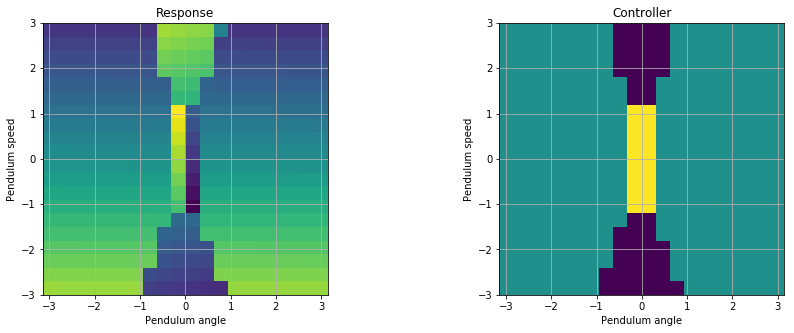

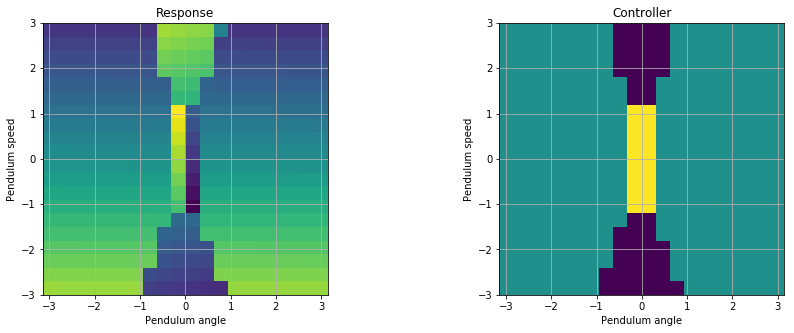

In [ ]:
# Train model
batch_size = 32
train_gen = DataGenerator(states[0:2,:].T,states[2,:].T,batch_size=batch_size)#generator(states[0:2,:].T,states[2,:].T,batch_size=batch_size)
plt.figure(figsize=(15,5))
run = time.time()
cb = TensorBoard(log_dir='./logs/run_%f'%run, batch_size=batch_size, write_graph=True)
test = run_cb()
model.goal_pred.fit_generator(train_gen,steps_per_epoch=states.shape[1]/batch_size, epochs=100,verbose=1,callbacks=[cb,test])

Demonstrate on gym environment, identified control policy should balance the pendulum

In [ ]:
# Test controller
import gym
ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME)
obs = env.reset() 

t = 0
done = False
while not done:

    state_polar = np.zeros((2,1)) 
    state_polar[0] = np.arctan2(obs[1],obs[0])
    state_polar[1] = obs[2]

    gains,weights = model.goal_pred.predict([state_polar.reshape(1,2),np.array([0.5]).reshape(1,1)])
    
    weights = weights.ravel()
    gains = gains.ravel()
    
    action = action = gains[0]*state_polar[0] + gains[1]*state_polar[1]
    
    obs,r,done, _ = env.step(action)
    env.render()
    t += 1

    done = False

    if t == 200:
        done = True
env.close()

## Visualise inferred controller clusters

Importantly, the inferred controller clustering shows that we have successfully identified the state-space regions corresponding to the three pendulum control laws. 

In [ ]:
# Plot state response
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(15,5))
th,v = np.meshgrid(np.linspace(-np.pi,np.pi,100),(np.linspace(-3,3,100)))
u = []
pi = []
for state_polar in np.vstack((th.ravel(),v.ravel())).T:

    gains,weights = model.goal_pred.predict([state_polar.reshape(1,2),np.array([0.5]).reshape(1,1)])
    
    weights = weights.ravel()
    gains = gains.ravel()
    
    action = gains[0]*state_polar[0] + gains[1]*state_polar[1]
    
    u.append(action)
    pi.append(np.argmax(weights))

plt.subplot(1,3,1)
plt.imshow(np.squeeze(np.array(u)).reshape(100,100),extent=(-np.pi,np.pi,-3,3))
plt.grid()
plt.ylabel('Pendulum speed')
plt.xlabel('Pendulum angle')
plt.title('SDN response')
plt.colorbar()


plt.subplot(1,3,2)
plt.imshow(np.squeeze(np.array(pi)).reshape(100,100),extent=(-np.pi,np.pi,-3,3))
plt.grid()
plt.title('Controller clusters')
plt.ylabel('Pendulum speed')
plt.xlabel('Pendulum angle')

plt.subplot(1,3,3)
plt.imshow(states[2,:].reshape(100,100),extent=(-np.pi,np.pi,-3,3))
plt.grid()
plt.title('Training data')
plt.ylabel('Pendulum speed')
plt.xlabel('Pendulum angle')
plt.colorbar()
plt.show()